<a href="https://colab.research.google.com/github/boomberung/traffic_signs_object_detection/blob/master/Custom_image_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Распознование дорожных знаков

##Загрузка изображения/изображений для распознования.


Запустите блок ниже, нажмите кнопку "Выбрать файлы" и загрузите изображение/изображения для распознавания.

In [1]:
from google.colab import files

uploaded = files.upload()

images = []
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  images.append(fn)

Saving image4.png to image4.png
User uploaded file "image4.png" with length 1079763 bytes


##Подготовка окржуения

Установка требуемых библиотек.

In [2]:
%cd
  
!git clone --quiet https://github.com/tensorflow/models.git

!apt-get install -qq protobuf-compiler python-tk

!pip install -q Cython contextlib2 pillow lxml matplotlib PyDrive

!pip install -q pycocotools

%cd ~/models/research
!protoc object_detection/protos/*.proto --python_out=.

import os
os.environ['PYTHONPATH'] += ':/content/models/research/:/content/models/research/slim/'

/root
Selecting previously unselected package libprotobuf10:amd64.
(Reading database ... 26397 files and directories currently installed.)
Preparing to unpack .../libprotobuf10_3.0.0-9.1ubuntu1_amd64.deb ...
Unpacking libprotobuf10:amd64 (3.0.0-9.1ubuntu1) ...
Selecting previously unselected package libprotoc10:amd64.
Preparing to unpack .../libprotoc10_3.0.0-9.1ubuntu1_amd64.deb ...
Unpacking libprotoc10:amd64 (3.0.0-9.1ubuntu1) ...
Selecting previously unselected package protobuf-compiler.
Preparing to unpack .../protobuf-compiler_3.0.0-9.1ubuntu1_amd64.deb ...
Unpacking protobuf-compiler (3.0.0-9.1ubuntu1) ...
Setting up libprotobuf10:amd64 (3.0.0-9.1ubuntu1) ...
Processing triggers for libc-bin (2.27-3ubuntu1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Setting up libprotoc10:amd64 (3.0.0-9.1ubuntu1) ...
Setting up protobuf-compiler (3.0.0-9.1ubuntu1) ...
Processing triggers for libc-bin (2.27-3ubuntu1) ...
/root/models/research


Импорты.

In [3]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

sys.path.append("..")
from object_detection.utils import ops as utils_ops

if StrictVersion(tf.__version__) < StrictVersion('1.9.0'):
  raise ImportError('Please upgrade your TensorFlow installation to v1.9.* or later!')
  
  
# Нужно для отрисовки изображений.
%matplotlib inline

from object_detection.utils import label_map_util

from object_detection.utils import visualization_utils as vis_util

%cd /content

/root


object_detection/utils/visualization_utils.py:27: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python2.7/dist-packages

In [4]:
!git clone https://github.com/boomberung/traffic_signs_object_detection.git

Cloning into 'traffic_signs_object_detection'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 13 (delta 4), reused 3 (delta 0), pack-reused 0
Unpacking objects: 100% (13/13), done.


##Подготовка модели

In [0]:
# Модель для загрузки.
MODEL_NAME = 'ssd_mobilenet_v1_coco_2018_01_28'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Путь frozen graph.
PATH_TO_FROZEN_GRAPH = 'traffic_signs_object_detection/frozen_inference_graph.pb'
# Путь до лейблов.
PATH_TO_LABELS = 'traffic_signs_object_detection/gtsdb_label_map.pbtxt'

Загрузка модели.

In [0]:
opener = urllib.request.URLopener()
opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
tar_file = tarfile.open(MODEL_FILE)
for file in tar_file.getmembers():
  file_name = os.path.basename(file.name)
  if 'frozen_inference_graph.pb' in file_name:
    tar_file.extract(file, os.getcwd())

Загрузка модели в память.

In [0]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

Загрузка лейблов.

In [0]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

Вспомогательная функция.

In [0]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

## Распознование знаков

In [0]:
# Размер отрисовывающихся изображений.
IMAGE_SIZE = (12, 8)

Функция отображения предиктов модели.

In [0]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')


      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

Распознование для каждого из входных изображений.

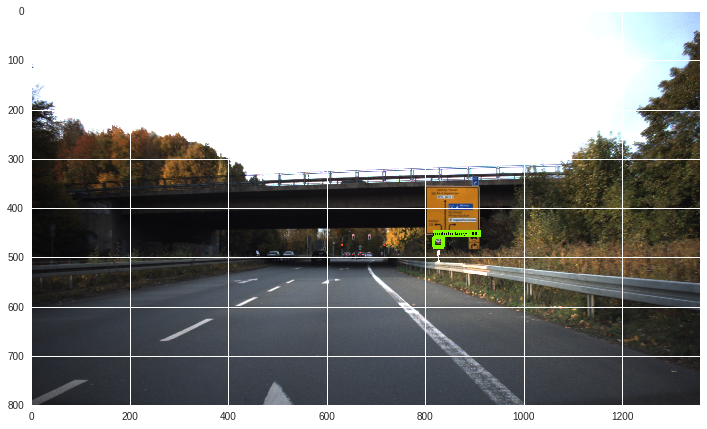

In [26]:
for image_path in images:
  image = Image.open(image_path)
  # Подготовка изображений.
  image_np = load_image_into_numpy_array(image)
  # Преобразование размерностей под входы модели: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Распознование.
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  # Визуализация.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)